In [1]:
import os
import math
import time
import struct
import json
import pandas as pd
import networkx as nx
import numpy as np
import numpy.linalg as npla
import scipy
import scipy.sparse.linalg as spla
from scipy import sparse
from scipy import linalg
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
%matplotlib tk

In [2]:
def pagerank1(E, return_vector = False, max_iters = 1000, tolerance = 1e-6):
    """compute page rank from dense adjacency matrix

    Inputs:
      E: adjacency matrix with links going from cols to rows.
         E is a matrix of 0s and 1s, where E[i,j] = 1 means 
         that web page (vertex) j has a link to web page i.
      return_vector = False: If True, return the eigenvector as well as the ranking.
      max_iters = 1000: Maximum number of power iterations to do.
      tolerance = 1e-6: Stop when the eigenvector norm changes by less than this.
      
    Outputs:
      ranking: Permutation giving the ranking, most important first
      vector (only if return_vector is True): Dominant eigenvector of PageRank matrix

    This computes page rank by the following steps:
    1. Add links from any dangling vertices to all vertices.
    2. Scale the columns to sum to 1.
    3. Add a constant matrix to represent jumping at random 15% of the time.
    4. Find the dominant eigenvector with the power method.
    5. Sort the eigenvector to get the rankings.

    The homework problem due February 22 asks you to rewrite this code so
    it takes input E as a scipy csr_sparse matrix, and then never creates 
    a full matrix or any large matrix other than E.
    """
    
    if type(E) is not np.ndarray:
        print('Warning, converting input from type', type(E), 'to dense array.')
        E = E.toarray()
                
    nnz = np.count_nonzero(E) # This call for sparse E may be different
    outdegree = np.sum(E, 0)  # This call for sparse E may be different
    nrows, n = E.shape

    assert nrows == n, 'E must be square'
    assert np.max(E) == 1 and np.sum(E) == nnz, 'E must contain only zeros and ones'
    
    #  1. Add links from any dangling vertices to all other vertices.
    #     E + F will be the matrix with the added links.

    F = np.zeros((n,n))
    for j in range(n):
        if outdegree[j] == 0:
            F[:,j] = np.ones(n)
            F[j,j] = 0
    
    #  2. Scale the columns to sum to 1.

    A = (E + F) / np.sum(E + F, 0)
    
    #  3. Add a constant matrix to represent jumping at random 15% of the time.

    S = np.ones((n,n)) / n
    m = 0.15
    M = (1 - m) * A + m * S
    
    #  4. Find the dominant eigenvector.
    #  Start with a vector all of whose entries are equal.

    e = np.ones(n)
    v = e / npla.norm(e)

    for iteration in range(max_iters):
        oldv = v
        
        v = M @ v
        eigval = npla.norm(v)
        v = v / eigval
        
        if npla.norm(v - oldv) < tolerance:
            break
    
    if npla.norm(v - oldv) < tolerance:
        print('Dominant eigenvalue is %f after %d iterations.\n' % (eigval, iteration+1))
    else:
        print('Did not converge to tolerance %e after %d iterations.\n' % (tolerance, max_iters))

    # Check that the eigenvector elements are all the same sign, and make them positive
    assert np.all(v > 0) or np.all(v < 0), 'Error: eigenvector is not all > 0 or < 0'
    vector = np.abs(v)
        
    #  5. Sort the eigenvector and reverse the permutation to get the rankings.
    ranking = np.argsort(vector)[::-1]

    if return_vector:
        return ranking, vector
    else:
        return ranking

In [3]:
def pagerank2(E, return_vector = False, max_iters = 1000, tolerance = 1e-6):
    """compute page rank from dense adjacency matrix

    Inputs:
      E: adjacency matrix with links going from cols to rows.
         E is a matrix of 0s and 1s, where E[i,j] = 1 means 
         that web page (vertex) j has a link to web page i.
      return_vector = False: If True, return the eigenvector as well as the ranking.
      max_iters = 1000: Maximum number of power iterations to do.
      tolerance = 1e-6: Stop when the eigenvector norm changes by less than this.
      
    Outputs:
      ranking: Permutation giving the ranking, most important first
      vector (only if return_vector is True): Dominant eigenvector of PageRank matrix

    This computes page rank by the following steps:
    1. Add links from any dangling vertices to all vertices.
    2. Scale the columns to sum to 1.
    3. Add a constant matrix to represent jumping at random 15% of the time.
    4. Find the dominant eigenvector with the power method.
    5. Sort the eigenvector to get the rankings.

    The homework problem due February 22 asks you to rewrite this code so
    it takes input E as a scipy csr_sparse matrix, and then never creates 
    a full matrix or any large matrix other than E.
    """
    """
    if type(E) is not np.ndarray:
        print('Warning, converting input from type', type(E), 'to dense array.')
        E = E.toarray()
    """
    np.seterr(divide='ignore', invalid = 'ignore')
    nnz = E.nnz # This call for sparse E may be different
    outdegree = np.sum(E, 0).A1  # This call for sparse E may be different
    #D = np.diag(1/outdegree)
    nrows, n = E.shape

    assert nrows == n, 'E must be square'
    assert np.max(E) == 1 and np.sum(E) == nnz, 'E must contain only zeros and ones'
    
    #preparation to save memory
    #E = E@D now is link matrix
    #print(E.toarray())
    ZeroCol = np.where(outdegree == 0)
    e = np.ones(n)
    v = e / npla.norm(e)
    for iteration in range(max_iters):
        oldv = v
        #E*V   E = E/np.sum(E,0)
        v = E.dot(0.85*oldv/outdegree)
        #mSv
        v += 0.15/n*sum(oldv)
        #F*v
        v += sum(oldv[ZeroCol]*(0.85/(n-1)))
        v[ZeroCol] -= oldv[ZeroCol]*(0.85/(n-1))
        v = v/npla.norm(v)
        if npla.norm(v - oldv) < tolerance:
            eigval = np.average(oldv/v)
            break
    
    if npla.norm(v - oldv) < tolerance:
        print('Dominant eigenvalue is %f after %d iterations.\n' % (eigval, iteration+1))
    else:
        print('Did not converge to tolerance %e after %d iterations.\n' % (tolerance, max_iters))
    # Check that the eigenvector elements are all the same sign, and make them positive
    assert np.all(v > 0) or np.all(v < 0), 'Error: eigenvector is not all > 0 or < 0'
    vector = np.abs(v)
        
    #  5. Sort the eigenvector and reverse the permutation to get the rankings.
    ranking = np.argsort(vector)[::-1]
    if return_vector:
        return ranking, vector
    else:
        return ranking

In [4]:
#Comparing the output of PG1 with PG2
E = np.load('PageRankEG1.npy')
r, v = pagerank1(E, return_vector = True)
print('r =', r)
print('v =', v)
print("maxvalue:",v[r[0]])
print("minvalue:",v[r[-1]])

Dominant eigenvalue is 1.000000 after 19 iterations.

r = [0 2 3 1]
v = [0.69648305 0.26828106 0.54477799 0.38230039]
maxvalue: 0.6964830451765137
minvalue: 0.2682810590636119


In [5]:
E = sparse.load_npz('PageRankEG1.npz')
r, v = pagerank2(E, return_vector = True)
print('r =', r)
print('v =', v)

Dominant eigenvalue is 1.000000 after 19 iterations.

r = [0 2 3 1]
v = [0.69648305 0.26828106 0.54477799 0.38230039]


In [6]:
E = sparse.load_npz('PageRankEG2.npz')
r, v = pagerank2(E, return_vector = True)
print('r =', r)
print('v =', v)

Dominant eigenvalue is 1.000000 after 2 iterations.

r = [3 2 1 0 4]
v = [0.40542854 0.40542854 0.57773567 0.57773567 0.06081428]


In [7]:
E = np.load('PageRankEG3.npy')
sitename = open('PageRankEG3.nodelabels').read().splitlines()
%time r = pagerank1(E)
print('r[:10] =', r[:10])
print()
for i in range(10):
    print('rank %d is page %3d: %s' % (i, r[i], sitename[r[i]]))

Dominant eigenvalue is 1.000000 after 56 iterations.

CPU times: user 16.4 ms, sys: 5.98 ms, total: 22.4 ms
Wall time: 15.7 ms
r[:10] = [  0   9  41 129  17  14   8  16  45  12]

rank 0 is page   0: http://www.harvard.edu
rank 1 is page   9: http://www.hbs.edu
rank 2 is page  41: http://search.harvard.edu:8765/custom/query.html
rank 3 is page 129: http://www.med.harvard.edu
rank 4 is page  17: http://www.gse.harvard.edu
rank 5 is page  14: http://www.hms.harvard.edu
rank 6 is page   8: http://www.ksg.harvard.edu
rank 7 is page  16: http://www.hsph.harvard.edu
rank 8 is page  45: http://www.gocrimson.com
rank 9 is page  12: http://www.hsdm.med.harvard.edu


In [8]:
E = sparse.load_npz('PageRankEG3.npz')
sitename = open('PageRankEG3.nodelabels').read().splitlines()
%time r= pagerank2(E)
print('r[:10] =', r[:10])
print()
for i in range(10):
    print('rank %d is page %3d: %s' % (i, r[i], sitename[r[i]]))

Dominant eigenvalue is 1.000000 after 56 iterations.

CPU times: user 47.2 ms, sys: 666 µs, total: 47.9 ms
Wall time: 12.6 ms
r[:10] = [  0   9  41 129  17  14   8  16  45  12]

rank 0 is page   0: http://www.harvard.edu
rank 1 is page   9: http://www.hbs.edu
rank 2 is page  41: http://search.harvard.edu:8765/custom/query.html
rank 3 is page 129: http://www.med.harvard.edu
rank 4 is page  17: http://www.gse.harvard.edu
rank 5 is page  14: http://www.hms.harvard.edu
rank 6 is page   8: http://www.ksg.harvard.edu
rank 7 is page  16: http://www.hsph.harvard.edu
rank 8 is page  45: http://www.gocrimson.com
rank 9 is page  12: http://www.hsdm.med.harvard.edu


In [9]:
#webGoogle
E = sparse.load_npz('webGoogle.npz')

In [15]:
%time r, v = pagerank2(E, return_vector = True)

Dominant eigenvalue is 1.000000 after 71 iterations.

CPU times: user 41.4 s, sys: 92.4 ms, total: 41.5 s
Wall time: 10.4 s


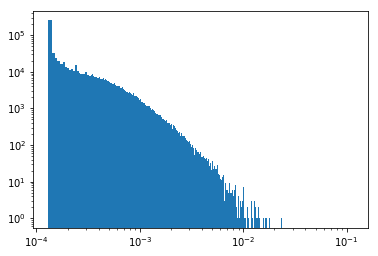

In [16]:
%matplotlib inline
plt.hist(v,bins="auto")
plt.gca().set_yscale("log")
plt.gca().set_xscale("log")

In [17]:
print("maxvalue:",v[r[0]])
print("minvalue:",v[r[-1]])

maxvalue: 0.11427415903139658
minvalue: 0.00013008094286810808


In [18]:
%time eigVal, eigVec = spla.eigs(E)

CPU times: user 20.6 s, sys: 203 ms, total: 20.8 s
Wall time: 5.42 s


In [ ]:
print(eigVal)

In [ ]:
d = np.array([1,2,3])
a = np.array([2,4,6])
c = d/a
c

In [ ]:
d += 1
d

In [ ]:
C = sparse.csr_matrix(np.array([[1,0], [0,2]]))
print(C)